In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix, classification_report

from plotly.offline import plot, init_notebook_mode
import plotly.graph_objs as go
import IPython

import keras
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


# Display data

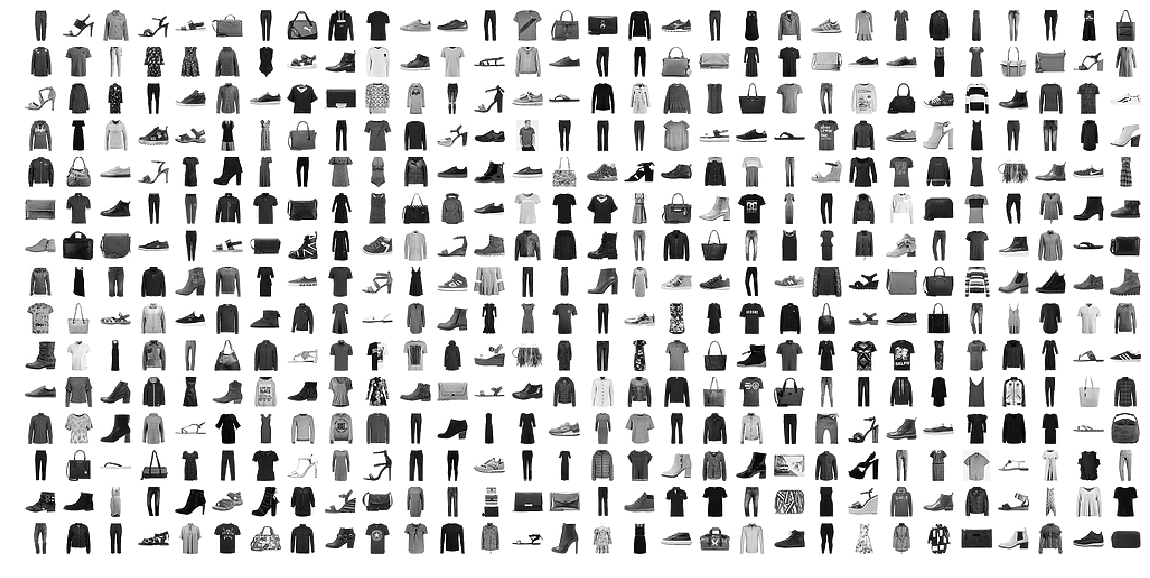

In [3]:
figure1, axis = plt.subplots(15, 30, figsize=(20,10))
for ax in axis.flatten():
    image_index = np.random.randint(0, x_train.shape[0]-1)
    ax.imshow(x_train[image_index], cmap=plt.cm.binary)
    ax.set_axis_off()
plt.show()

In [4]:
colours = ['red', 'green', 'blue', 'cyan', 'magenta', 'yellow',
           'black', 'white', 'orange', 'purple']
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
               'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_legend = pd.DataFrame(dict(class_name=class_names, colour=colours))
class_legend

,class_name,colour
0,T-shirt,red
1,Trouser,green
2,Pullover,blue
3,Dress,cyan
4,Coat,magenta
5,Sandal,yellow
6,Shirt,black
7,Sneaker,white
8,Bag,orange
9,Ankle boot,purple


# Check classes balancing

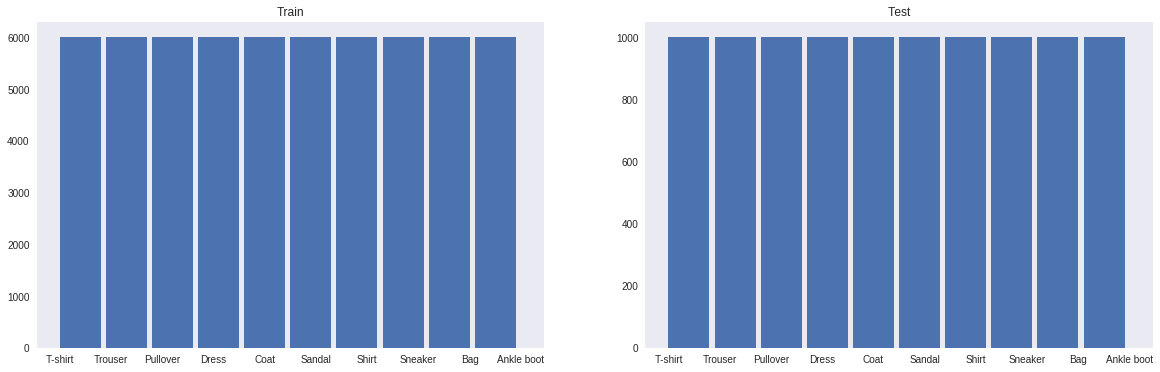

In [5]:
figure2, axis = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
for ax, title, data in zip(axis, ['Train','Test'], [y_train, y_test]):
    unique = np.unique(data)
    ax.hist(data, bins=len(unique), width=0.8)
    ax.set_title(f'{title}')
    ax.set_xticks(range(len(unique)))
    ax.set_xticklabels(class_legend.class_name.values)
    ax.grid(False)

As we can see all classes are balanced.

# Projection Visualization

What is a Projection?
A projection is a method for taking these high dimensional vections and project them into a lower dimensional space.

There are 3 main projections:
- PCA (Principal Component Analysis) which tries to find the top 10 principle components of the data
- t-SNE (T-distributed Stochastic Neighbor Embedding) which tries to preserve local structure, but will distort global structure
- UMAP (Uniform Manifold Approximation and Projection) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [0]:
objects = x_train.reshape(x_train.shape[0], 28 * 28) / 255

## Principal Component Analysis

In [0]:
pca_decomposer_2d = PCA(n_components=2)
objects_pca_2d = pca_decomposer_2d.fit_transform(objects)

In [0]:
def plot_decomposition(X, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(20, 8))
    for coord, colour in zip([X[np.where(y == i)[0]] for i in range(len(class_legend))], class_legend.colour.values):
        ax.scatter(coord[:,0], coord[:,1], c=colour, label=class_legend.loc[class_legend.colour == colour, 'class_name'].values[0])
        ax.legend()
        ax.set_title(title, y=1.02, fontsize=20)

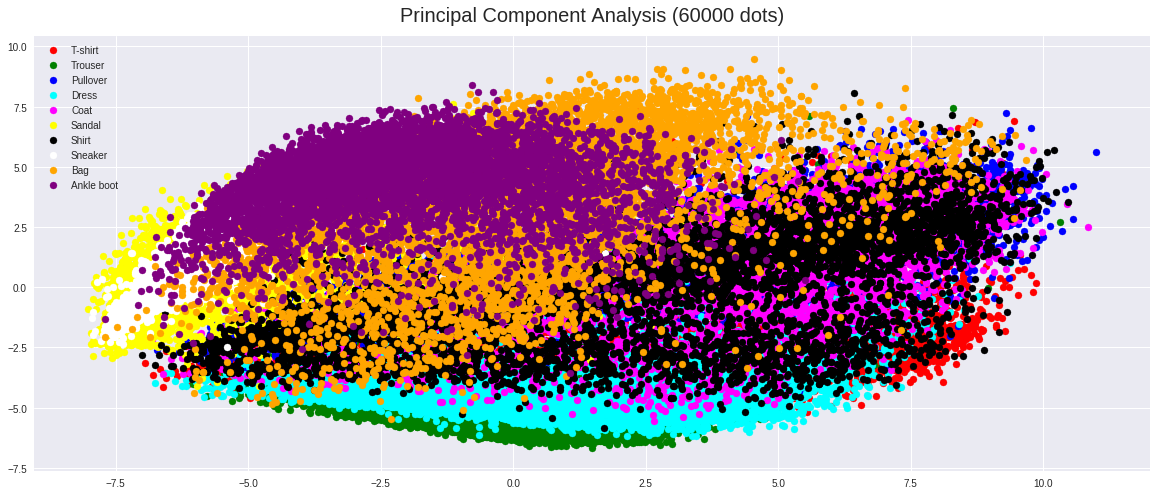

In [9]:
plot_decomposition(objects_pca_2d, y_train, title='Principal Component Analysis (60000 dots)')

## Uniform Manifold Approximation and Projection

In [0]:
%%time
umap_decomposer_2d = UMAP(n_components=2, random_state=42)
objects_umap_2d = umap_decomposer_2d.fit_transform(objects)

CPU times: user 2min 3s, sys: 5.23 s, total: 2min 8s
Wall time: 1min 58s


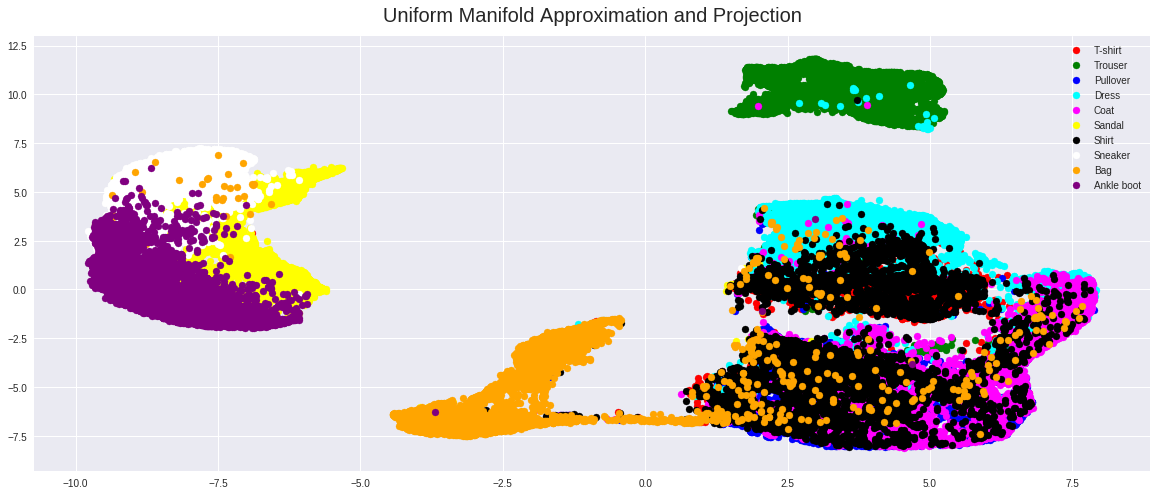

In [0]:
plot_decomposition(objects_umap_2d, y_train, title='Uniform Manifold Approximation and Projection')

## T-distributed Stochastic Neighbor Embedding
Let's define the optimal number of iterations, which we need for t-sne. I will compare 300, 400, 500 and 750 iterations.

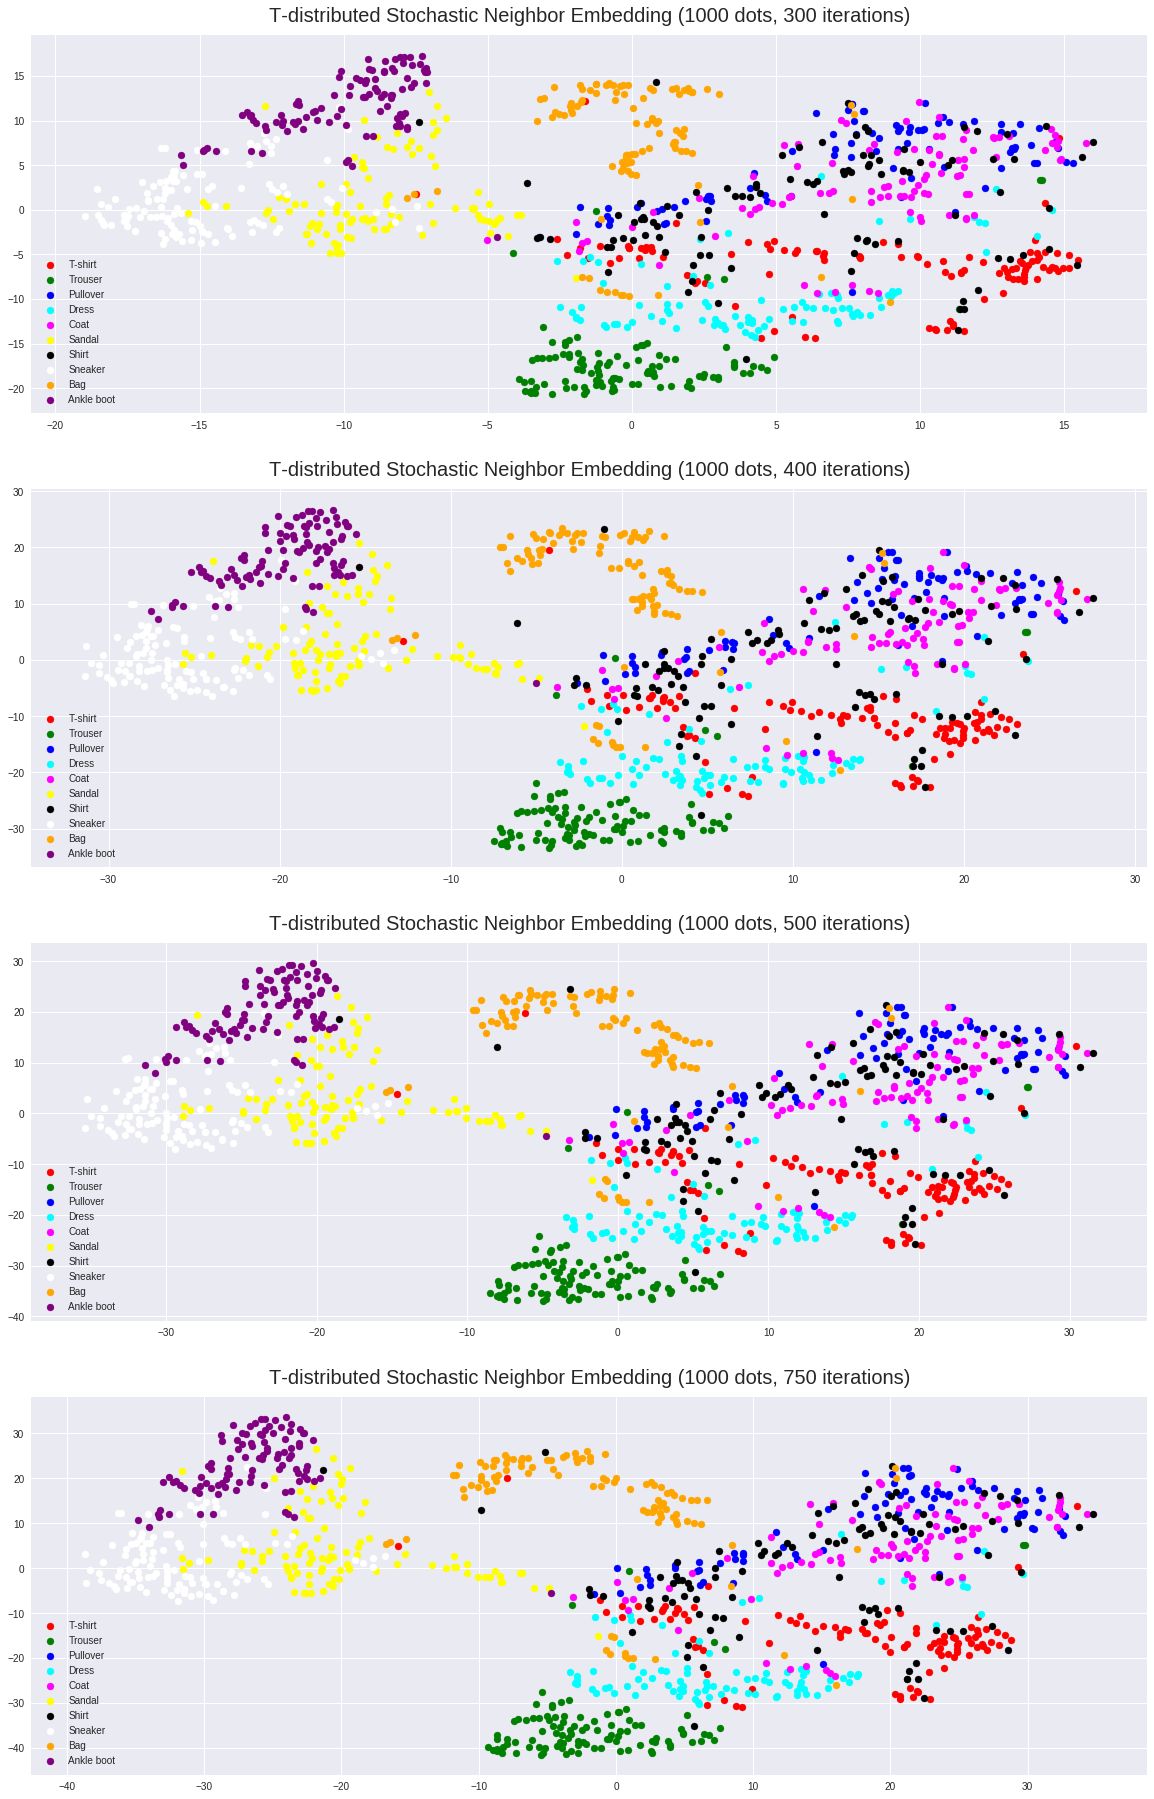

In [0]:
figure3, axis = plt.subplots(nrows=4, ncols=1, figsize=(20, 32))
for n_iter, ax in zip([300, 400, 500, 750], axis):
    vars()[f'tsne_{n_iter}'] = TSNE(n_components=2, init='pca', random_state=42, perplexity= 30, n_iter=n_iter)
    X_tsne = eval(f'tsne_{n_iter}.fit_transform(objects[:1000])')
    plot_decomposition(X_tsne, y_train[:len(X_tsne)], ax=ax, title=f'T-distributed Stochastic Neighbor Embedding (1000 dots, {n_iter} iterations)')
plt.show()

As we can see **n_iters = 400** is the optimal value for T-SNE.

In [0]:
%%time
tsne400_decomposer_2d = TSNE(n_components=2, init='pca', random_state=42, perplexity= 30, n_iter=400)
objects_tsne400_2d = tsne400_decomposer_2d.fit_transform(objects[:10000])

CPU times: user 4min 16s, sys: 282 ms, total: 4min 17s
Wall time: 4min 16s


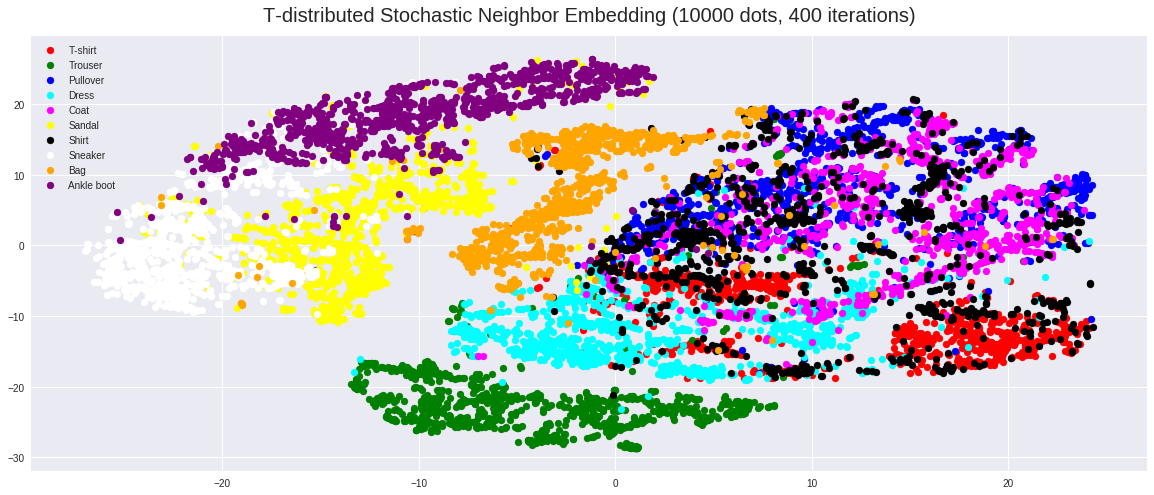

In [0]:
plot_decomposition(objects_tsne400_2d, y_train[:len(objects_tsne400_2d)],
                   title='T-distributed Stochastic Neighbor Embedding (10000 dots, 400 iterations)')

In [15]:
def enable_plotly_in_cell():
    display(IPython.core.display.HTML('''\
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))
    init_notebook_mode(connected=False)

def matplotlib_to_plotly(cmap, pl_entries):
    """
    This function converts matplotlib colormap to plotly colormap
    """
    h = 1.0/(pl_entries-1)
    pl_colorscale = []
    
    for k in range(pl_entries):
        C = list(map(np.uint8, np.array(cmap(k*h)[:3])*255))
        pl_colorscale.append([k*h, 'rgb'+str((C[0], C[1], C[2]))])
        
    return pl_colorscale

enable_plotly_in_cell()

Output hidden; open in https://colab.research.google.com to view.

In [0]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [0]:
%%time
pca_decomposer_3d = PCA(n_components=3)
objects_pca_3d = pca_decomposer_3d.fit_transform(objects[:10000])

In [0]:
def get_figure(X, y):
    trace = go.Scatter3d(x=X[:, 0], y=X[:, 1], z=X[:, 2], 
                         mode='markers',
                         marker=dict(color=y,
                                     colorscale=matplotlib_to_plotly(plt.cm.gist_rainbow, 10),
                                     line=dict(color='black', width=1)),
                         text = [class_legend.loc[i,'class_name'] for i in y],
                         hoverinfo='text')
    layout = go.Layout(scene=
                       dict(
                            xaxis=dict(ticks='', showticklabels=False),
                            yaxis=dict(ticks='', showticklabels=False),
                            zaxis=dict(ticks='', showticklabels=False),
                           ),
                       height=600,
                       margin=go.layout.Margin(l=20, r=20, b=20, t=20, pad=4))
    return go.Figure(data=[trace], layout=layout)

In [0]:
plot(get_figure(objects_pca_3d, y_train[:len(objects_pca_3d)]),
     filename='fashion_pca.html')

In [0]:
%%time
tsne400_decomposer_3d = TSNE(n_components=3, init='pca', random_state=42, perplexity= 30, n_iter=400)
objects_tsne400_3d = tsne400_decomposer_3d.fit_transform(objects[:10000])

CPU times: user 7min 27s, sys: 1.29 s, total: 7min 28s
Wall time: 7min 27s


In [0]:
plot(get_figure(objects_tsne400_3d, y_train[:len(objects_tsne400_3d)]),
     filename='fashion_tsne.html')

In [11]:
%%time
umap_decomposer_3d = UMAP(n_components=3, random_state=42)
objects_umap_3d = umap_decomposer_3d.fit_transform(objects[:10000])

CPU times: user 41.8 s, sys: 899 ms, total: 42.7 s
Wall time: 42 s


In [16]:
plot(get_figure(objects_umap_3d, y_train[:len(objects_umap_3d)]),
     filename='fashion_umap.html')

'file:///content/gdrive/My Drive/Github/Fashion-MNIST-Dataset/fashion_umap.html'

# Models
Let's compare models with 1, 2 and 3 Conv layers
## Split the training data into train and validate arrays

In [33]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_train = x_train.reshape(*x_train.shape, 1) / 255 
x_test = x_test.reshape(*x_test.shape, 1) / 255
x_validate = x_validate.reshape(*x_validate.shape, 1) /255

print('x_train shape: {}'.format(x_train.shape))
print('x_test shape: {}'.format(x_test.shape))
print('x_validate shape: {}'.format(x_validate.shape))

x_train shape: (48000, 28, 28, 1)
x_test shape: (10000, 28, 28, 1)
x_validate shape: (12000, 28, 28, 1)


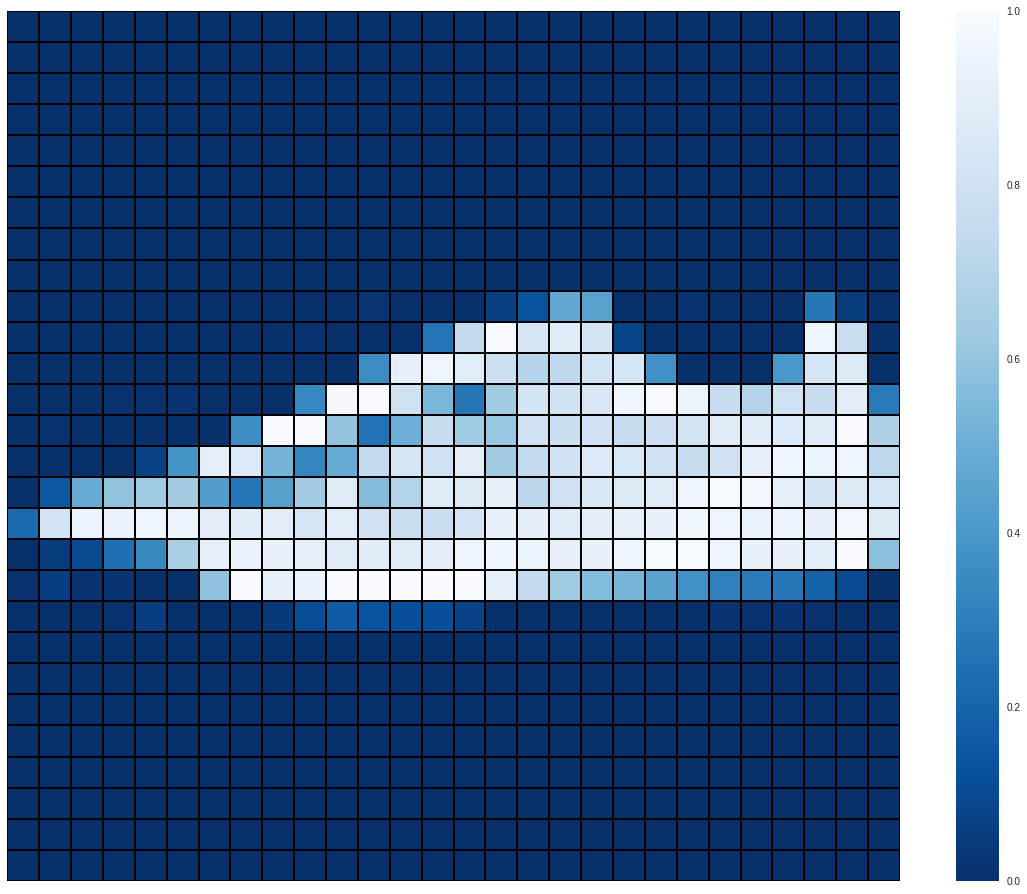

In [0]:
fig, ax = plt.subplots(figsize=(20,16))
sb.heatmap(x_train[0].reshape(28,28), vmax=1, annot=True, ax=ax,
           cmap=plt.cm.Blues_r, cbar=True, linecolor='black', linewidths=1,
           xticklabels=False, yticklabels=False)
plt.show()

In [0]:
cnn_model_1 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1), name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout'),
    Flatten(name='flatten'),
    Dense(32, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name='1_Conv_Layer')

cnn_model_2 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1), name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.2, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Flatten(name='flatten'),
    Dense(64, activation='relu', name='Dense'),
    Dense(10, activation='softmax', name='Output')
], name='2_Conv_Layers')

cnn_model_3 = Sequential([
    Conv2D(32, kernel_size=3, activation='relu', input_shape=(28, 28, 1),
           kernel_initializer='he_normal', name='Conv2D-1'),
    MaxPooling2D(pool_size=2, name='MaxPool'),
    Dropout(0.25, name='Dropout-1'),
    Conv2D(64, kernel_size=3, activation='relu', name='Conv2D-2'),
    Dropout(0.25, name='Dropout-2'),
    Conv2D(128, kernel_size=3, activation='relu', name='Conv2D-3'),
    Dropout(0.4, name='Dropout-3'),
    Flatten(name='flatten'),
    Dense(128, activation='relu', name='Dense'),
    Dropout(0.4, name='Dropout'),
    Dense(10, activation='softmax', name='Output')
], name='3_Conv_Layers')

cnn_models = [cnn_model_1, cnn_model_2, cnn_model_3]

In [0]:
for model in cnn_models:
    print(f' {model.name} '.join(['*'*25]*2))
    model.summary()

************************* 1_Conv_Layer *************************
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Conv2D-1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
MaxPool (MaxPooling2D)       (None, 13, 13, 32)        0         
_________________________________________________________________
Dropout (Dropout)            (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
Dense (Dense)                (None, 32)                173088    
_________________________________________________________________
Output (Dense)               (None, 10)                330       
Total params: 173,738
Trainable params: 173,738
Non-trainable params: 0
_____

In [0]:
# train the models and save results to a dict
history_dict = {}
batch_size = 512

for model in cnn_models:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(),
        metrics=['accuracy']
    )
    
    history = model.fit(
        x_train, y_train,
        batch_size=batch_size,
        epochs=50, verbose=1,
        validation_data=(x_validate, y_validate)
    )
    
    history_dict[model.name] = history

Instructions for updating:
Use tf.cast instead.
Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 7s 152us/step - loss: 0.7677 - acc: 0.7524 - val_loss: 0.4754 - val_acc: 0.8347
Epoch 2/50
48000/48000 [==============================] - 2s 37us/step - loss: 0.4408 - acc: 0.8459 - val_loss: 0.4043 - val_acc: 0.8572
Epoch 3/50
48000/48000 [==============================] - 2s 37us/step - loss: 0.3842 - acc: 0.8662 - val_loss: 0.3630 - val_acc: 0.8716
Epoch 4/50
48000/48000 [==============================] - 2s 35us/step - loss: 0.3578 - acc: 0.8760 - val_loss: 0.3516 - val_acc: 0.8761
Epoch 5/50
48000/48000 [==============================] - 2s 35us/step - loss: 0.3372 - acc: 0.8811 - val_loss: 0.3257 - val_acc: 0.8828
Epoch 6/50
48000/48000 [==============================] - 2s 35us/step - loss: 0.3179 - acc: 0.8887 - val_loss: 0.3111 - val_acc: 0.8881
Epoch 7/50
48000/48000 [==============================] - 2s 34us/step - loss: 

In [0]:
def plot_history(history_dict, metrics=['acc', 'val_acc', 'loss', 'val_loss'],
                 titles=['Training Accuracy', 'Validation Accuracy', 'Training Loss', 'Validation Loss']):
    figure, axis = plt.subplots(nrows=int(len(titles)/2), ncols=2, figsize=(20, 5*int(len(titles)/2)))
    for model_name in history_dict.keys():
        for ax, title, metric in zip(axis.flatten(), titles, metrics):
            ax.plot(history_dict[model_name].history[metric], label=model_name, linewidth=2)
            ax.set_title(title, fontsize=18)
            ax.legend(fontsize=12)
    if len(axis.shape) == 1:
        axis[0].set_xlabel('Epochs')
        axis[1].set_xlabel('Epochs')
    else:
        axis[-1, 0].set_xlabel('Epochs')
        axis[-1, 1].set_xlabel('Epochs')
        

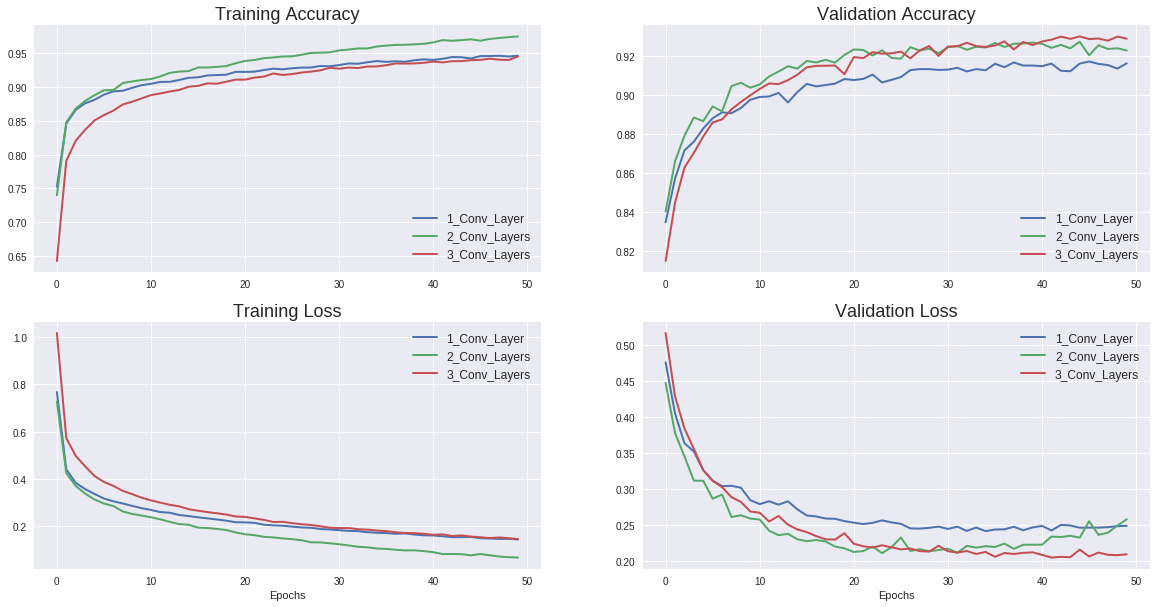

In [0]:
plot_history(history_dict)

In [0]:
def plot_confusion_matrix(y_true, y_pred, ax, vmax=1):
    matrix = confusion_matrix(y_true,y_pred)
    normed_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(normed_matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black', linewidths=1,
               xticklabels=class_names)
    ax.set_title('Confusion matrix', y=1.20, fontsize=16)
    ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

def rose_plot(values, labels, ax, title, **params):
    angle_step = 360/len(labels)
    ax.bar(np.deg2rad(np.arange(0, 360, angle_step)), values, 
           width=np.deg2rad(angle_step), bottom=0.0, linewidth=2,
           edgecolor='black', **params)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.arange(0, 360, angle_step), labels=labels)
    ax.set_yticks([])
    ax.set_title(title, y=1.10, fontsize=16)
    
def boxplot_f1score(values, ax, **params):
    bp = ax.boxplot(values, vert=False, widths=[0.6], patch_artist=True)
    for element in ['boxes', 'whiskers', 'fliers', 'means', 'caps']:
        plt.setp(bp[element], color='black', linewidth=2)
    plt.setp(bp['medians'], color='black', linewidth=5)
    for patch in bp['boxes']:
        patch.set(facecolor='cyan')
    ax.set_title('f1-score distribution', y=1.10, fontsize=16)
    
def plot_f1score_per_class(X, values, mean_val, labels, ax, **params):
    ax.bar(X, values, align='center', color='red', label='f1-score', edgecolor='black', linewidth=2)
    ax.plot((-1,len(labels)), [mean_val]*2, "k--", label='weighted f1-score')
    ax.grid(False)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels)
    ax.set_title('f1-score', fontsize=16)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
              fancybox=True, shadow=True, ncol=2)
    
def multi_report(y_true, y_pred, labels, output_dict=False, confusion_vmax=1):
    gridsize = (10, 12)
    figure = plt.figure(figsize=(20, 15))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=6, rowspan=6, )
    ax2 = plt.subplot2grid(gridsize, (0, 6), colspan=6, rowspan=3)
    ax3 = plt.subplot2grid(gridsize, (3, 6), colspan=6, rowspan=3)
    ax4 = plt.subplot2grid(gridsize, (6, 0), colspan=4, rowspan=4, projection='polar')
    ax5 = plt.subplot2grid(gridsize, (6, 4), colspan=4, rowspan=4, projection='polar')
    ax6 = plt.subplot2grid(gridsize, (6, 8), colspan=4, rowspan=4, projection='polar')
    
    plot_confusion_matrix(y_true, y_pred, vmax=confusion_vmax, ax=ax1)
    report = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    X, f1score, recall, precision = [],[],[],[]
    for name in class_names:
        X.append(class_legend[class_legend.class_name == name].index[0])
        f1score.append(report[name]['f1-score'])
        recall.append(report[name]['recall'])
        precision.append(report[name]['precision'])
        
    plot_f1score_per_class(X, f1score, mean_val=report['macro avg']['f1-score'],
                           ax=ax2, labels=labels)
    boxplot_f1score(f1score, ax3)
    rose_plot(precision, ax=ax4, title='Precision', labels=labels)
    rose_plot(recall, ax=ax5, title='Recall', labels=labels, color='green')
    rose_plot(f1score, ax=ax6, title='f1-score', labels=labels, color='red')
    
    plt.subplots_adjust(hspace=5)
    if output_dict:
        return report

In [0]:
y_pred = cnn_model_3.predict_classes(x_test)

In [0]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

     T-shirt       0.87      0.87      0.87      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.90      0.88      0.89      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.87      0.91      0.89      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.79      0.77      0.78      1000
     Sneaker       0.97      0.97      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.97      0.98      0.97      1000

   micro avg       0.93      0.93      0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



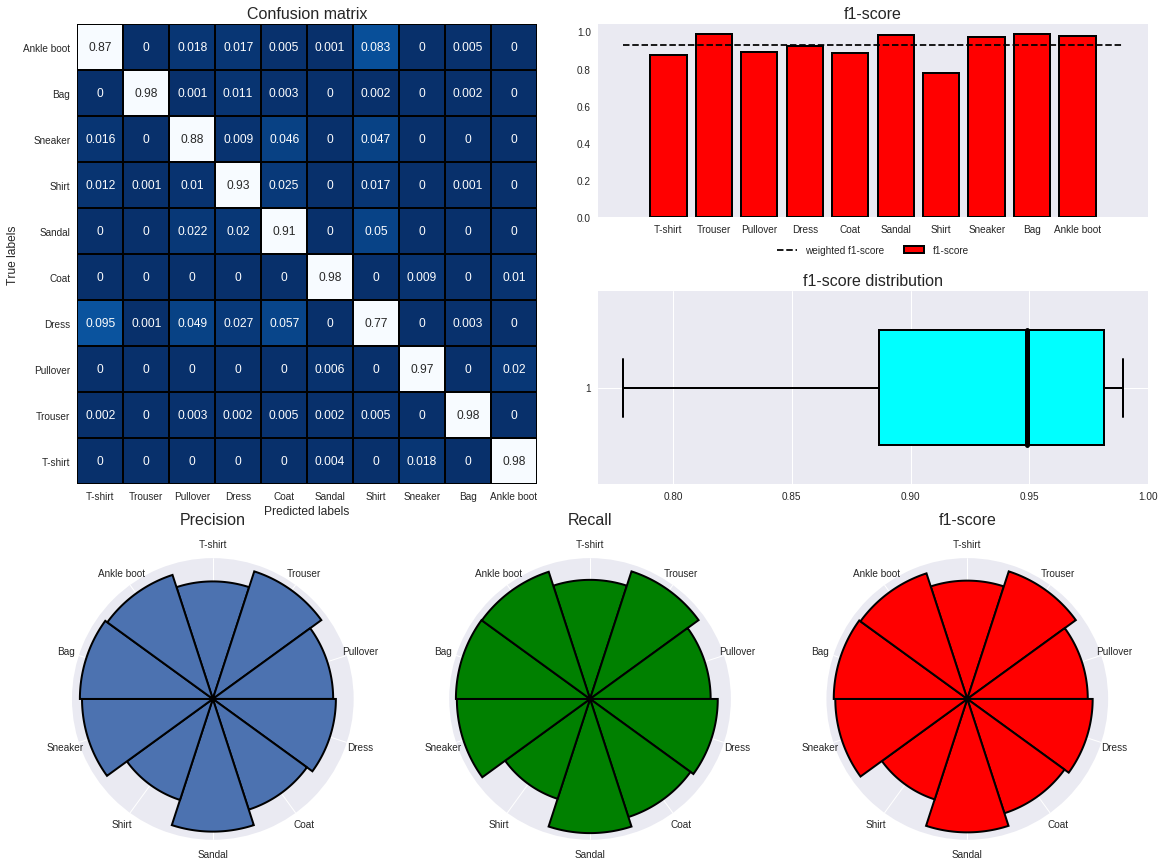

In [0]:
multi_report(y_test, y_pred, labels=class_names, confusion_vmax=0.7)

# Pixel importance

In [0]:
%%time
# Build a forest and compute the pixel importances
forest = ExtraTreesClassifier(n_estimators=1000,
                              max_features='sqrt',
                              n_jobs=4, 
                              random_state=42)

forest.fit(objects[:30000], y_train[:30000])

CPU times: user 15min 10s, sys: 3.37 s, total: 15min 13s
Wall time: 7min 44s


In [0]:
pixel_importances = forest.feature_importances_
pixel_importances = pixel_importances.reshape(28,28)

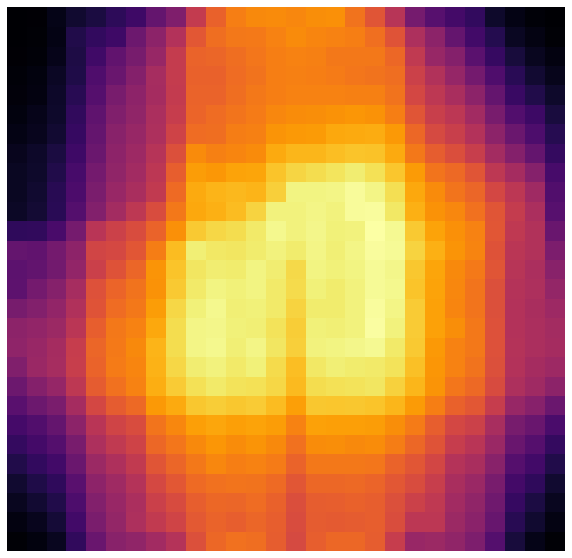

In [0]:
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(pixel_importances, cbar=False, ax=ax, cmap=plt.cm.inferno,
           xticklabels=False, yticklabels=False)
plt.show()

# Autoencoder

In [0]:
autoencoder_1 = Sequential([
    ## encoding architecture
    Dense(1500, input_shape=(784,), activation='relu', name='encode_layer1'),
    Dense(1000, activation='relu', name='encode_layer2'),
    Dense(500, activation='relu', name='encode_layer3'),

    ## latent view
    Dense(10, activation='sigmoid', name='latent_view'),

    ## decoding architecture
    Dense(500, activation='relu', name='decode_layer1'),
    Dense(1000, activation='relu', name='decode_layer2'),
    Dense(1500, activation='relu', name='decode_layer3'),

    ## output layer
    Dense(784, name='output')
])

# another construction principle
## input layer
#input_layer = Input(shape=(784,))

## encoding architecture
#encode_layer1 = Dense(1500, activation='relu')(input_layer)
#encode_layer2 = Dense(1000, activation='relu')(encode_layer1)
#encode_layer3 = Dense(500, activation='relu')(encode_layer2)

## latent view
#latent_view   = Dense(10, activation='sigmoid')(encode_layer3)

## decoding architecture
#decode_layer1 = Dense(500, activation='relu')(latent_view)
#decode_layer2 = Dense(1000, activation='relu')(decode_layer1)
#decode_layer3 = Dense(1500, activation='relu')(decode_layer2)

## output layer
#output_layer  = Dense(784)(decode_layer3)

#autoencoder_1 = Model(input_layer, output_layer)

In [29]:
autoencoder_1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encode_layer1 (Dense)        (None, 1500)              1177500   
_________________________________________________________________
encode_layer2 (Dense)        (None, 1000)              1501000   
_________________________________________________________________
encode_layer3 (Dense)        (None, 500)               500500    
_________________________________________________________________
latent_view (Dense)          (None, 10)                5010      
_________________________________________________________________
decode_layer1 (Dense)        (None, 500)               5500      
_________________________________________________________________
decode_layer2 (Dense)        (None, 1000)              501000    
_________________________________________________________________
decode_layer3 (Dense)        (None, 1500)              1501500   
__________

In [0]:
validation = x_validate.reshape(x_validate.shape[0], 28*28)

In [36]:
autoencoder_1.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history_autoenc_1 = autoencoder_1.fit(objects, objects, epochs=40, batch_size=1024, validation_data=(validation, validation), callbacks=[early_stopping])

Train on 60000 samples, validate on 12000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 56us/step - loss: 0.0278 - val_loss: 0.0168
Epoch 2/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0159 - val_loss: 0.0153
Epoch 3/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0153 - val_loss: 0.0151
Epoch 4/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0150 - val_loss: 0.0148
Epoch 5/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0148 - val_loss: 0.0146
Epoch 6/40
60000/60000 [==============================] - 3s 43us/step - loss: 0.0146 - val_loss: 0.0145
Epoch 7/40
60000/60000 [==============================] - 3s 43us/step - loss: 0.0145 - val_loss: 0.0143
Epoch 8/40
60000/60000 [==============================] - 3s 43us/step - loss: 0.0142 - val_loss: 0.0143
Epoch 9/40
60000/60000 [==============================] - 3s 43us/step - loss: 0.0142 - val_loss: 0.0140
Epoch

In [0]:
"""
autoencoder_2 = Sequential([
    Conv2D(64, kernel_size=3, activation='relu', input_shape=(28, 28, 1),
           padding='same', name='encoded_conv_layer1'),
    MaxPooling2D(pool_size=2, padding='same', name='encoded_layer1'),
    Conv2D(32, kernel_size=3, activation='relu',
           padding='same', name='encoded_conv_layer2'),
    MaxPooling2D(pool_size=2, padding='same', name='encoded_layer2'),
    Conv2D(16, kernel_size=3, activation='relu',
           padding='same', name='encoded_layer3'),
    MaxPooling2D(pool_size=2, padding='same', name='latent_view'),
    
    Conv2D(16, kernel_size=3, activation='relu',
           padding='same', name='decoded_conv_layer1'),
    UpSampling2D(size=2, name='decoded_layer1'),
    Conv2D(32, kernel_size=3, activation='relu',
           padding='same', name='decoded_conv_layer2'),
    UpSampling2D(size=2, name='decoded_layer2'),
    Conv2D(64, kernel_size=3, activation='relu',
           padding='same', name='decoded_conv_layer3'),
    UpSampling2D(size=2, name='decoded_layer3'),
    Conv2D(1, kernel_size=3, padding='same', name='output_layer')
], name='Conv_autoencoder')
"""
# input layer
input_layer = Input(shape=(28, 28, 1))
# encoding architecture
encoded_layer1 = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
encoded_layer1 = MaxPooling2D( (2, 2), padding='same')(encoded_layer1)
encoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded_layer1)
encoded_layer2 = MaxPooling2D( (2, 2), padding='same')(encoded_layer2)
encoded_layer3 = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded_layer2)
latent_view    = MaxPooling2D( (2, 2), padding='same')(encoded_layer3)
# decoding architecture
decoded_layer1 = Conv2D(16, (3, 3), activation='relu', padding='same')(latent_view)
decoded_layer1 = UpSampling2D((2, 2))(decoded_layer1)
decoded_layer2 = Conv2D(32, (3, 3), activation='relu', padding='same')(decoded_layer1)
decoded_layer2 = UpSampling2D((2, 2))(decoded_layer2)
decoded_layer3 = Conv2D(64, (3, 3), activation='relu')(decoded_layer2)
decoded_layer3 = UpSampling2D((2, 2))(decoded_layer3)
output_layer   = Conv2D(1, (3, 3), padding='same')(decoded_layer3)
# compile the model
autoencoder_2 = Model(input_layer, output_layer)
autoencoder_2.compile(optimizer='adam', loss='mse')

In [52]:
autoencoder_2.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
history_autoenc_2 = autoencoder_2.fit(x_train, x_train, epochs=40, batch_size=1024, validation_data=(x_validate, x_validate), callbacks=[early_stopping])

Train on 48000 samples, validate on 12000 samples
Epoch 1/40
48000/48000 [==============================] - 11s 226us/step - loss: 0.0751 - val_loss: 0.0388
Epoch 2/40
48000/48000 [==============================] - 6s 134us/step - loss: 0.0327 - val_loss: 0.0273
Epoch 3/40
48000/48000 [==============================] - 6s 135us/step - loss: 0.0239 - val_loss: 0.0216
Epoch 4/40
48000/48000 [==============================] - 6s 134us/step - loss: 0.0205 - val_loss: 0.0195
Epoch 5/40
48000/48000 [==============================] - 6s 135us/step - loss: 0.0190 - val_loss: 0.0184
Epoch 6/40
48000/48000 [==============================] - 6s 134us/step - loss: 0.0180 - val_loss: 0.0175
Epoch 7/40
48000/48000 [==============================] - 6s 134us/step - loss: 0.0173 - val_loss: 0.0169
Epoch 8/40
48000/48000 [==============================] - 6s 134us/step - loss: 0.0167 - val_loss: 0.0166
Epoch 9/40
48000/48000 [==============================] - 6s 135us/step - loss: 0.0162 - val_loss: 0.

In [0]:
encoder_history_dict = {}
encoder_history_dict['Flatten'] = history_autoenc_1
encoder_history_dict['Conv'] = history_autoenc_2

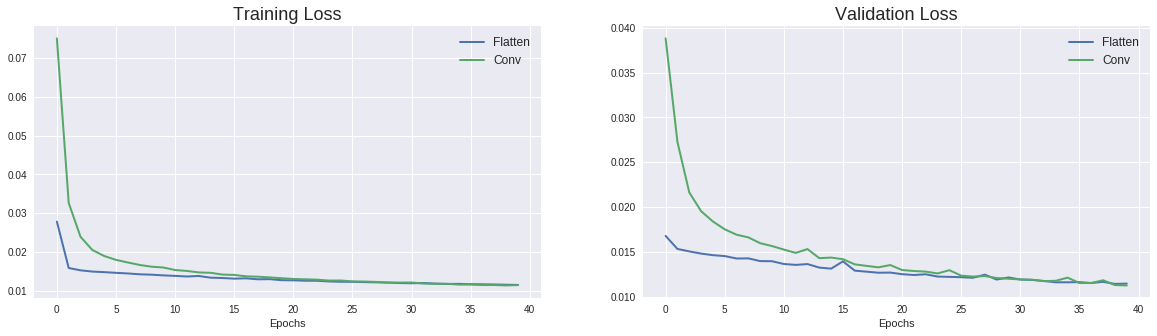

In [59]:
plot_history(encoder_history_dict, metrics=['loss','val_loss'], titles=['Training Loss', 'Validation Loss'])

In [0]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1500)              1177500   
_________________________________________________________________
dense_10 (Dense)             (None, 1000)              1501000   
_________________________________________________________________
dense_11 (Dense)             (None, 500)               500500    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                5010      
_________________________________________________________________
dense_13 (Dense)             (None, 500)               5500      
_________________________________________________________________
dense_14 (Dense)             (None, 1000)              501000    
__________

In [0]:
autoencoder.compile(optimizer='adam', loss='mse')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')
autoencoder.fit(objects, objects, epochs=40, batch_size=1024, validation_data=(validation, validation), callbacks=[early_stopping])

Train on 60000 samples, validate on 12000 samples
Epoch 1/40
60000/60000 [==============================] - 3s 56us/step - loss: 0.0231 - val_loss: 0.0153
Epoch 2/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0146 - val_loss: 0.0141
Epoch 3/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0139 - val_loss: 0.0138
Epoch 4/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0137 - val_loss: 0.0137
Epoch 5/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0136 - val_loss: 0.0135
Epoch 6/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0135 - val_loss: 0.0137
Epoch 7/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0133 - val_loss: 0.0133
Epoch 8/40
60000/60000 [==============================] - 2s 42us/step - loss: 0.0134 - val_loss: 0.0132
Epoch 9/40
60000/60000 [==============================] - 3s 42us/step - loss: 0.0131 - val_loss: 0.0134
Epoch

In [0]:
from imgaug import augmenters

noise = augmenters.SaltAndPepper(0.2)
seq_object = augmenters.Sequential([noise])

def add_noise(array):
    noised_array = array.copy()
    return seq_object.augment_images(np.array([noised_array]) * 255)[0] / 255
    

def plot_autoencoding(image_index):
    figure, axis = plt.subplots(nrows=4, ncols=5, figsize=(20,12))
    for ax, index in zip(axis[0], image_index):
        sb.heatmap(objects[index].reshape(28,28), ax=ax, cmap=plt.cm.binary,
                   cbar=False, square=True, xticklabels=False, yticklabels=False)
    noised_images = [add_noise(objects[i].reshape(28,28)) for i in image_index]
    for ax, im in zip(axis[1], noised_images):
        sb.heatmap(im, ax=ax, cmap=plt.cm.binary,
                   cbar=False, square=True, xticklabels=False, yticklabels=False)
    predicted_1 = [autoencoder_1.predict(np.array([im.flatten()]))[0].reshape(28,28) for im in noised_images]
    for ax, image in zip(axis[2], predicted_1):
        sb.heatmap(image.reshape(28,28), ax=ax, cmap=plt.cm.binary,
                   cbar=False, square=True, xticklabels=False, yticklabels=False)
    predicted_2 = [autoencoder_2.predict(np.array([im.reshape(28,28,1)]))[0] for im in noised_images]
    for ax, image in zip(axis[3], predicted_2):
        sb.heatmap(image.reshape(28,28), ax=ax, cmap=plt.cm.binary,
                   cbar=False, square=True, xticklabels=False, yticklabels=False)
    plt.show()

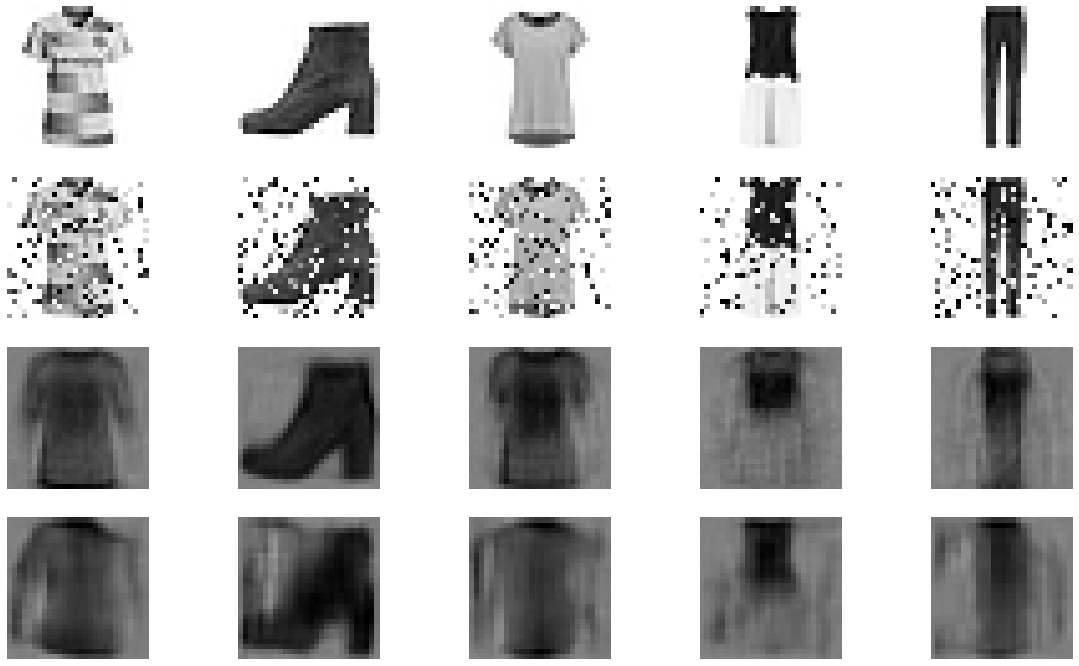

In [101]:
image_index = np.random.randint(0, objects.shape[0], size=5)
plot_autoencoding(image_index)